Jupyter notebook 的主要操作單位是 cell，每個 cell 可以是代碼或者文本。您可以用滑鼠或者方向鍵來選擇 cell，然後用 Enter 鍵進入編輯模式，或者用 Esc 鍵退出編輯模式。在編輯模式下，您可以修改 cell 的內容，並用 Shift + Enter 鍵執行 cell 並跳到下一個 cell。在非編輯模式下，您可以用快捷鍵來對 cell 進行操作，例如：

A 鍵：在當前 cell 的上方插入一個新的 cell
B 鍵：在當前 cell 的下方插入一個新的 cell
M 鍵：將當前 cell 轉換為文本模式
Y 鍵：將當前 cell 轉換為代碼模式
D + D 鍵：刪除當前 cell
Z 鍵：撤銷刪除 cell 的操作

可以的，您只需要將 cell 轉換為文本模式，然後就可以使用 markdown 語法來編寫格式化的文本了。例如，您可以用 # 來表示標題，用 * 來表示斜體，用 ** 來表示粗體，用 > 來表示引用，用 - 來表示無序列表，用 1. 來表示有序列表，等等。您可以在這裡查看更多的 markdown 語法。

# Webcam input

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
cap = cv2.VideoCapture(1)

In [6]:
ret, frame = cap.read()

cv2.imshow('oxxostudio', frame)        # 賦予開啟的視窗名稱，開啟圖片
cv2.waitKey(0) 

-1

# Geometery Correction

(只是用非魚眼的CASE)

到時候的作法是先在地板貼個正方形膠帶，然後給機器自己抓

若不更動「攝影機角度」，只要第一次使用時校正就可以

這裡用別人的圖片+拿小畫家畫個長方形假裝是膠帶來示意

In [129]:
img = cv2.imread('R.jfif')

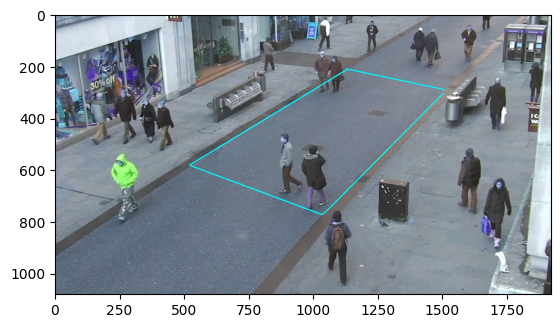

In [279]:
plt.imshow(img)
plt.show()

找到邊緣、擬和邊緣、計算交點、去除重複焦點、將焦點順時鐘排列

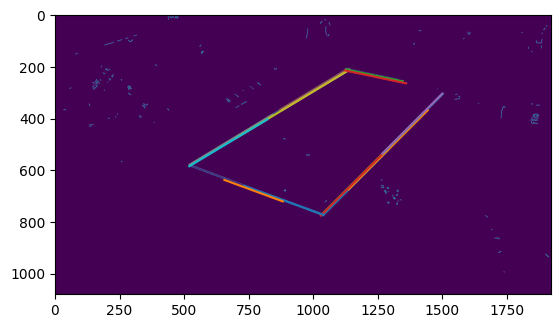

[-1.5633208  -1.56916815 -1.56772128 -1.56935898]
[array([1129.71155427, 1519.68421053,  514.54295189, 1039.2673031 ]), array([209.77605226, 291.31578947, 580.30231469, 771.7326969 ])]


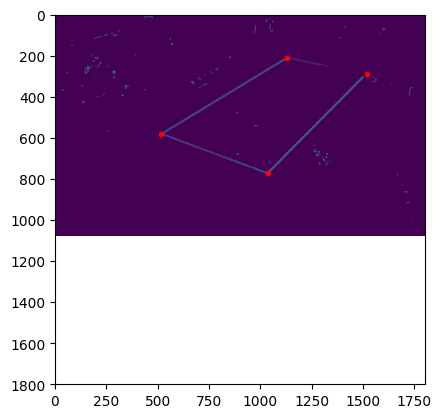

In [282]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find edges
edges = cv2.Canny(img, 500, 600)


# image	8-bit, single-channel binary source image. The image may be modified by the function.
# lines	Output vector of lines. Each line is represented by a 4-element vector (x1,y1,x2,y2) , where (x1,y1) and (x2,y2) are the ending points of each detected line segment.
# rho	Distance resolution of the accumulator in pixels.
# theta	Angle resolution of the accumulator in radians.
# threshold	Accumulator threshold parameter. Only those lines are returned that get enough votes ( >threshold ).
# minLineLength	Minimum line length. Line segments shorter than that are rejected.
# maxLineGap	Maximum allowed gap between points on the same line to link them.

# find lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 60, minLineLength=220, maxLineGap=100)
for i in range(len(lines)):
    plt.plot([np.array(lines)[i][0][0],np.array(lines)[i][0][2]],[np.array(lines)[i][0][1],np.array(lines)[i][0][3]])
plt.imshow(edges)
plt.show()

# len(lines)
intersections = []
for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        x1, y1, x2, y2 = lines[i][0]
        x3, y3, x4, y4 = lines[j][0]
        
        m = (y1-y2)/(x1-x2)
        n = (y3-y4)/(x3-x4)
        a = y1 - m*x1
        b = y3 - n*x3
        
        if abs(m*n) < 0.4 and  abs(m-n)>0.01:
            px = (b-a)/(m-n)
            py = m*px + a
#             plt.plot([x1,x2],[y1,y2])
#             plt.plot([x3,x4],[y3,y4])
#             plt.plot(px,py,'r.')
#             plt.title('%f' %(m*n))
#             plt.imshow(edges)
#             plt.xlim([0,1800])
#             plt.ylim([1800,0])
#             plt.show()
            if px >0 and py > 0:
                intersections.append([px, py])


# remove duplicates
threshold = 100
data = np.array(intersections)

# 建立一個空的布林遮罩
mask = []

# 比較每兩個項是否相近，如果是就將遮罩設為True

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if abs(data[i][0] - data[j][0]) + abs(data[i][1] - data[j][1]) < threshold:
            mask.append(j)

# 使用np.delete()函數刪除遮罩為True的項
intersections = [np.delete(data.T[0], mask) ,np.delete(data.T[1], mask)]

# # sort intersections by clockwise order
center = np.mean(intersections, axis=0)
angles = np.arctan2(intersections[1] - center[1], intersections[0] - center[0])
print(angles)
indices = np.argsort(angles)
intersections[0] = intersections[0][indices]
intersections[1] = intersections[1][indices]


# Display the image
plt.imshow(edges)
plt.plot(intersections[0],intersections[1],'r.')
print(intersections)
plt.xlim([0,1800])
plt.ylim([1800,0])
plt.show()

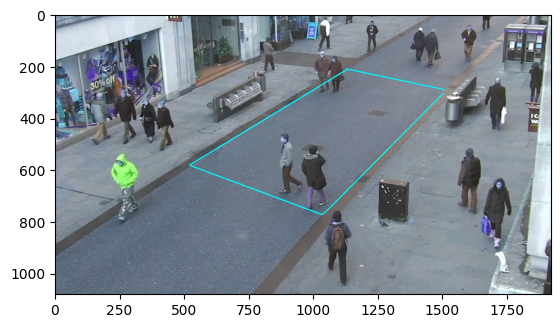

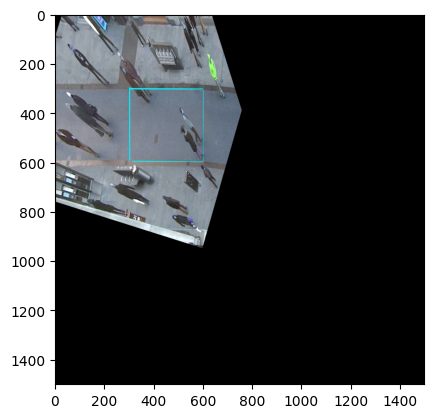

In [283]:

# get perspective transform matrix
pts1 = np.float32(np.array(intersections).T)
pts2 = np.float32([[300, 300], [300, 600],[600, 300],[600, 600]])
M = cv2.getPerspectiveTransform(pts1, pts2)

# warp perspective
dst = cv2.warpPerspective(img, M, (1500, 1500))

# show result
plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()
# cv2.waitKey(0)

# 人物辨識重心以及地面投影

變形之後人的高度會跟著拉長，要將位置對應到地面才行

from
https://github.com/shliang0603/Yolov4_DeepSocial/blob/master/src/deepsocial.py

In [ ]:
class birds_eye:

    def __init__(self, image, cordinates):
        self.original = image.copy()
        self.image = image
        self.c, self.r = image.shape[0:2]
        pst2 = np.float32(cordinates)
        pst1 = np.float32([[0, 0], [self.r, 0], [0, self.c], [self.r, self.c]])
        self.transferI2B = cv2.getPerspectiveTransform(pst1, pst2)
        self.transferB2I = cv2.getPerspectiveTransform(pst2, pst1)
        self.img2bird()

    def img2bird(self):
        self.bird = cv2.warpPerspective(self.image, self.transferI2B, (self.r, self.c))
        return self.bird

    def bird2img(self):
        self.image = cv2.warpPerspective(self.bird, self.transferB2I, (self.r, self.c))
        return self.image

    def setImage(self, img):
        self.image = img

    def setBird(self, bird):
        self.bird = bird

    def convrt2Bird(self, img):
        return cv2.warpPerspective(img, self.transferI2B, (self.r, self.c))

    def convrt2Image(self, bird):
        return cv2.warpPerspective(bird, self.transferB2I, (self.r, self.c))

    def projection_on_bird(self, p):
        M = self.transferI2B
        px = (M[0][0] * p[0] + M[0][1] * p[1] + M[0][2]) / (M[2][0] * p[0] + M[2][1] * p[1] + M[2][2])
        py = (M[1][0] * p[0] + M[1][1] * p[1] + M[1][2]) / (M[2][0] * p[0] + M[2][1] * p[1] + M[2][2])
        return (int(px), int(py))

    def projection_on_image(self, p):
        M = self.transferB2I
        px = (M[0][0] * p[0] + M[0][1] * p[1] + M[0][2]) / (M[2][0] * p[0] + M[2][1] * p[1] + M[2][2])
        py = (M[1][0] * p[0] + M[1][1] * p[1] + M[1][2]) / (M[2][0] * p[0] + M[2][1] * p[1] + M[2][2])
        return (int(px), int(py))

    def points_projection_on_image(self, center, radius):
        x, y = center
        points = midPointCircleDraw(x, y, radius)
        original = np.array([points], dtype=(np.float32))
        cvd = cv2.perspectiveTransform(original, self.transferB2I)
        return cvd[0]


In [23]:
# 導入套件
import cv2
import torch
import torchvision

# 設定webcam來源為預設攝影機
cap = cv2.VideoCapture(0)

# 設定Fast-R-CNN模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 設定行人類別編號為1
pedestrian_class = 1

# 設定偵測門檻值為0.8
threshold = 0.8

# 開始偵測迴圈


C:\Users\oun12\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\oun12\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\oun12/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
97.9%

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [27]:
while True:
    # 讀取webcam畫面
    ret, frame = cap.read()
    if not ret:
        break

    # 將畫面轉換成tensor格式
    frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float()

    # 使用模型進行物件偵測，並取得結果
    output = model([frame_tensor])

    # 取得偵測到的物件類別、信心分數、邊界框座標等資訊
    labels = output[0]['labels'].numpy()
    scores = output[0]['scores'].detach().numpy()
    boxes = output[0]['boxes'].numpy()

    # 初始化行人計數器和邊界框顏色列表
    pedestrian_count = 0
    colors = []

    # 迴圈遍歷每個偵測到的物件，並過濾出行人類別且信心分數高於門檻值者，並對其畫出邊界框和計算行人數量。
    for i in range(len(labels)):
        if labels[i] == pedestrian_class and scores[i] > threshold:
            pedestrian_count += 1

            # 隨機產生一個BGR顏色值，並加入到列表中。
            color = (int(torch.randint(0, 256, ())), int(torch.randint(0, 256, ())), int(torch.randint(0, 256, ())))
            colors.append(color)

            # 取得邊界框座標，並轉換成整數。
            x1, y1, x2, y2 = boxes[i]
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)

            # 在畫面上畫出邊界框和信心分數。
            cv2.rectangle(frame, (x1,y1), (x2,y2), color=color , thickness=3)
            cv2.putText(frame,str(round(scores[i],3)),(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX ,fontScale=0.5,color=color ,thickness=3)


     # 在畫面上顯示行人數量。
    cv2.putText(frame,'Pedestrian Count: '+str(pedestrian_count),(10,30),cv2.FONT_HERSHEY_SIMPLEX ,fontScale=1)
    #print
     # 顯示處理後的畫面。
    cv2.imshow('Pedestrian Detection', frame)

     # 按下q鍵結```python束偵測迴圈。
    if cv2.waitKey(1) & 0xFF == ord('q'):
         break

# 釋放webcam資源並關閉視窗。
cap.release()
cv2.destroyAllWindows()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.